In [1]:
!pip install -Uqq fastbook

     |████████████████████████████████| 727kB 7.8MB/s 
     |████████████████████████████████| 194kB 16.0MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
     |████████████████████████████████| 1.2MB 20.9MB/s 
     |████████████████████████████████| 61kB 10.4MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from fastai.text.all import *
import pandas as pd
import json
import os
from sklearn.model_selection import train_test_split

In [4]:
import zipfile
file = '/content/News_Category_Dataset_v2.json'
if not os.path.exists(file):
  zip_file = '/content/gdrive/My Drive/fastai/News_Category_Dataset_v2.json.zip'
  with zipfile.ZipFile(zip_file, 'r') as zip_ref:
      zip_ref.extractall('/content/')

In [5]:
df = pd.read_json(file, lines=True)
df.index.rename('id', inplace=True)
df = df.reset_index()
df = df.rename(columns={'headline':'text'})
df.head()

,id,category,text,authors,link,short_description,date
0,0,CRIME,"There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV",Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89,She left her husband. He killed their children. Just another day in America.,2018-05-26
1,1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song,Andy McDonald,https://www.huffingtonpost.com/entry/will-smith-joins-diplo-and-nicky-jam-for-the-official-2018-world-cup-song_us_5b09726fe4b0fdb2aa541201,Of course it has a song.,2018-05-26
2,2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-grant-marries_us_5b09212ce4b0568a880b9a8c,The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.,2018-05-26
3,3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carrey-adam-schiff-democrats_us_5b0950e8e4b0fdb2aa53e675,The actor gives Dems an ass-kicking for not fighting hard enough against Donald Trump.,2018-05-26
4,4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-margulies-trump-poop-bag_us_5b093ec2e4b0fdb2aa53df70,"The ""Dietland"" actress said using the bags is a ""really cathartic, therapeutic moment.""",2018-05-26


In [6]:
train_val_idx, test_idx = train_test_split(range(len(df)), test_size=0.1, random_state=42, shuffle=True)
test = df.iloc[test_idx]
train_validation = df.iloc[train_val_idx]
print(f"Number of training: {len(train_val_idx)}, Number of testing: {len(test_idx)}")

Number of training: 180767, Number of testing: 20086


In [7]:
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.1, random_state=42, shuffle=True)
train_validation['is_valid'] = False
train_validation.loc[train_validation.id.isin(val_idx), 'is_valid'] = True
train_validation.groupby('is_valid').size()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


is_valid
False    162690
True      18077
dtype: int64

In [ ]:
train_validation.sample(5)

,id,category,text,authors,link,short_description,date,is_valid
146610,146610,STYLE & BEAUTY,On Cate Blanchett and Why She Should Win Another Oscar,"Prabal Gurung, Contributor\nFashion designer",https://www.huffingtonpost.com/entry/monday-muse-on-cate-blanc_us_5b9d77d3e4b03a1dcc885d81,"Last weekend, I went to see Woody Allen's Blue Jasmine featuring Cate Blanchett and I walked out instantly knowing who our next Muse would be. Cate's performance stayed with me for days. It got me thinking about talent, pure, raw talent.",2013-08-30,False
40332,40332,POLITICS,Friday's Morning Email: Trump's Labor Pick Opposes Significantly Raising Minimum Wage,Lauren Weber,https://www.huffingtonpost.com/entry/fridays-morning-email-trumps-labor-pick-opposes-significantly-raising-minimum-wage_us_584aaa76e4b04c8e2baf4cf0,Meet Andrew Puzder.,2016-12-09,False
82552,82552,CRIME,Police Kill Armed Black Man In St. Louis On Anniversary Of Another Officer-Involved Shooting,Sebastian Murdock and Mariah Stewart,https://www.huffingtonpost.com/entry/police-kill-armed-man-in-st-louis-other-suspect-flees_us_55d4db82e4b0ab468d9f8a8c,Protests later broke out at the scene of the shooting.,2015-08-19,False
114792,114792,COLLEGE,How Would You Redefine Study Abroad?,"Amelia Friedman, ContributorCo-Founder at Hatch",https://www.huffingtonpost.com/entry/how-would-you-redefine-st_b_5675588.html,"A new initiative at the International Institute of Education is sparking conversation, asking us how we can increase the cultural awareness in our students and encourage them to learn in environments outside of their comfort zone.",2014-08-14,False
199154,199154,HOME & LIVING,It Makes All the Difference in the World How Art Is Viewed,"Christina Craemer, Contributor\nInterior designer",https://www.huffingtonpost.com/entry/it-makes-all-the-difference_us_5b9b551ce4b03a1dcc76b331,"As I was leaving I realized what a wonderful evening this had been and how it reminded me of just how important the holistic relationship of art to space, time and surroundings really is.",2012-02-15,False


## Finetunning Model

In [8]:
huffpost = DataBlock(blocks=(TextBlock.from_df('text'), CategoryBlock),
                     get_x=ColReader('text'),
                     get_y=ColReader('category'),
                     splitter=ColSplitter())

In [9]:
dls = huffpost.dataloaders(train_validation, bs=64, seq_len=50)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [10]:
dls.show_batch(max_n=6)

,text,category
0,"xxbos xxmaj chats with xxmaj xxunk xxmaj xxunk , xxmaj michelle xxmaj phillips , xxmaj lee xxmaj xxunk , xxmaj ian xxmaj thomas and xxmaj young xxmaj gun xxmaj silver xxmaj fox 's xxmaj shawn xxmaj lee , xxmaj plus xxmaj joey xxmaj alexander , xxmaj xxunk , xxmaj xxunk xxmaj xxunk , m xxmaj ross xxmaj perkins , xxmaj morgan 's xxmaj road , xxmaj xxunk , xxmaj dave mcgraw & xxmaj mandy xxmaj xxunk , xxmaj unconscious xxmaj xxunk , i xxmaj the xxmaj mighty , and xxmaj the xxmaj junior xxmaj league xxmaj exclusives",ENTERTAINMENT
1,"xxbos ' how xxmaj do xxmaj we xxmaj treat the xxmaj little xxmaj people , xxmaj joan ? ' i xxmaj asked . xxmaj and xxmaj she xxmaj said , ' why , xxmaj we xxmaj treat xxmaj them xxmaj better . xxmaj we xxmaj only xxmaj s -- t on xxmaj people at xxmaj our xxmaj level or xxmaj higher . '",ENTERTAINMENT
2,"xxbos a - sides xxmaj with xxmaj jon xxmaj chattman : xxmaj the xxup walk xxup the xxup moon "" dance xxmaj off "" : xxmaj eli xxmaj xxunk xxmaj talks xxmaj hard xxmaj about xxmaj recreating ' 80s "" nuggets of xxmaj nerdy xxmaj goodness """,ENTERTAINMENT
3,xxbos xxmaj real xxmaj stories xxmaj of xxmaj americans xxmaj who xxmaj will xxmaj be xxmaj affected xxmaj by xxmaj the xxmaj proposed xxmaj changes xxmaj to xxmaj the xxup aca — xxmaj and xxmaj what xxup you xxmaj can xxmaj do xxmaj to xxmaj fight,POLITICS
4,"xxbos xxmaj greece 's xxmaj xxunk xxmaj railway , xxmaj one of the xxmaj world 's xxmaj most xxmaj spectacular xxmaj train xxmaj rides : xxmaj spring xxmaj break 2016 , xxmaj breaking xxmaj bad on the xxmaj looney xxmaj front - xxmaj part 4",TRAVEL
5,xxbos xxmaj trevor xxmaj noah 's xxmaj interview xxmaj with xxmaj tomi xxmaj lahren xxmaj is a xxmaj perfect xxmaj example xxmaj of xxmaj why xxmaj the xxmaj white xxmaj liberal ' discourse ' xxmaj fetish xxmaj is xxmaj so xxmaj damn xxmaj absurd .,POLITICS


In [11]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [ ]:
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.453103,2.130135,0.424573,03:46


epoch,train_loss,valid_loss,accuracy,time
0,1.800438,1.551368,0.563921,04:21
1,1.559305,1.418899,0.599602,04:20
2,1.398875,1.323755,0.621287,04:20
3,1.228384,1.310966,0.624219,04:20


In [ ]:
learn.show_results()

,text,category,category_
0,"xxbos xxmaj masters xxmaj live xxmaj blog , xxmaj final xxmaj round xxmaj saturday : xxmaj masters xxmaj tracker xxmaj for xxmaj the xxmaj final xxmaj round xxmaj sunday xxmaj at xxmaj augusta xxmaj national xxmaj as xxmaj bubba xxmaj watson xxmaj and xxmaj jordan xxmaj spieth xxmaj start xxmaj with xxmaj the xxmaj lead",SPORTS,SPORTS
1,xxbos xxmaj the xxmaj election xxmaj of a so - called xxmaj moderate xxmaj president xxmaj of xxmaj the xxmaj xxunk xxmaj state xxmaj has xxmaj only xxmaj resulted xxmaj to xxunk xxmaj increase xxmaj in xxmaj the xxmaj number xxmaj of xxmaj executions xxmaj carried xxmaj out xxmaj against xxmaj iranian,POLITICS,POLITICS
2,"xxbos xxmaj the xxmaj best xxmaj political xxmaj jokes xxmaj of xxmaj the xxmaj week : xxmaj fallon xxmaj on xxmaj paul xxmaj ryan , xxmaj letterman xxmaj on xxmaj chris xxmaj christie , xxmaj stewart xxmaj on xxmaj voter xxup i d xxmaj laws & xxmaj more ( video )",COMEDY,COMEDY
3,"xxbos xxmaj how the xxmaj world xxmaj has xxmaj changed : xxmaj it xxmaj is xxmaj now xxmaj one . xxmaj how the xxmaj fashion xxmaj world xxmaj has xxmaj changed : xxmaj it , xxmaj too , xxmaj is xxmaj now xxmaj one .",STYLE & BEAUTY,STYLE & BEAUTY
4,"xxbos xxmaj xxunk xxmaj xxunk , xxmaj orphan xxmaj turned xxmaj model , xxmaj on xxmaj her xxmaj first xxmaj fashion xxmaj week xxmaj and xxmaj why xxmaj she 's xxmaj the xxmaj next xxmaj tyra xxmaj banks ( photos )",STYLE & BEAUTY,STYLE & BEAUTY
5,"xxbos xxmaj the xxmaj best xxmaj political xxmaj jokes xxmaj of xxmaj the xxmaj week : xxmaj letterman xxmaj on xxup gop xxmaj convention xxmaj hurricane , xxmaj leno xxmaj on xxmaj todd xxmaj akin & xxmaj more ( video )",COMEDY,COMEDY
6,"xxbos xxmaj jimmy xxmaj fallon 's xxmaj thank xxmaj you xxmaj notes xxmaj for xxup ll xxmaj cool xxup j , xxmaj here xxmaj comes xxmaj honey xxmaj boo xxmaj boo & xxmaj no xxmaj smoking xxmaj signs ( video )",COMEDY,COMEDY
7,"xxbos xxmaj gwen xxmaj tan , xxmaj writer & xxmaj surface xxmaj mag xxmaj intern , xxmaj on xxmaj the xxmaj one xxmaj thing xxmaj you xxmaj must xxmaj do xxmaj before xxmaj you xxmaj go xxmaj to xxmaj bed",STYLE & BEAUTY,STYLE & BEAUTY
8,xxbos xxmaj this xxmaj retired xxmaj coal xxmaj miner xxmaj has xxmaj black xxmaj lung xxmaj disease . xxmaj he 's xxmaj fighting xxmaj to xxmaj make xxmaj sure xxmaj no xxmaj one xxmaj else xxmaj gets xxmaj it .,POLITICS,POLITICS


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

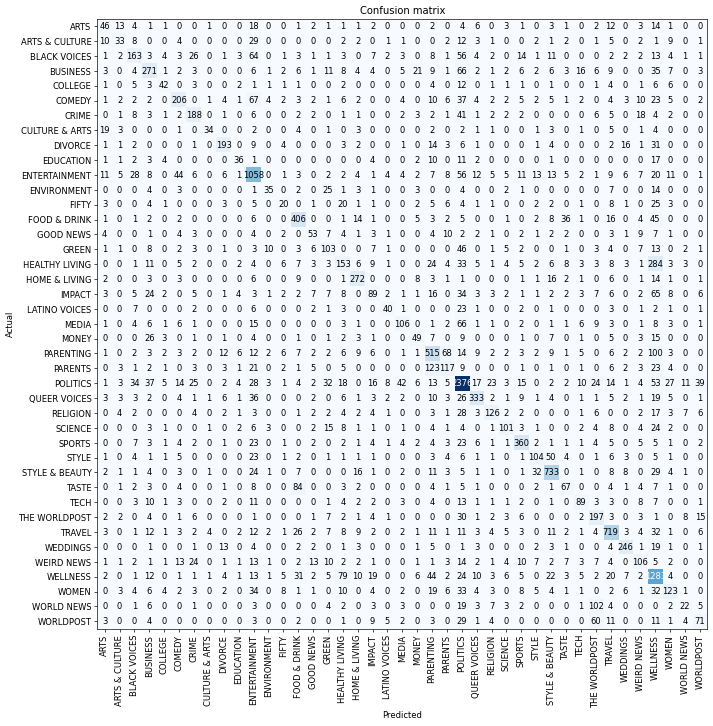

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=10)

[('HEALTHY LIVING', 'WELLNESS', 284),
 ('PARENTS', 'PARENTING', 123),
 ('WORLD NEWS', 'THE WORLDPOST', 102),
 ('PARENTING', 'WELLNESS', 100),
 ('TASTE', 'FOOD & DRINK', 84),
 ('WELLNESS', 'HEALTHY LIVING', 79),
 ('PARENTING', 'PARENTS', 68),
 ('COMEDY', 'ENTERTAINMENT', 67),
 ('BUSINESS', 'POLITICS', 66),
 ('MEDIA', 'POLITICS', 66),
 ('IMPACT', 'WELLNESS', 65),
 ('BLACK VOICES', 'ENTERTAINMENT', 64),
 ('WORLDPOST', 'THE WORLDPOST', 60),
 ('BLACK VOICES', 'POLITICS', 56),
 ('ENTERTAINMENT', 'POLITICS', 56),
 ('POLITICS', 'WELLNESS', 53),
 ('STYLE', 'STYLE & BEAUTY', 50),
 ('GREEN', 'POLITICS', 46),
 ('FOOD & DRINK', 'WELLNESS', 45),
 ('ENTERTAINMENT', 'COMEDY', 44),
 ('WELLNESS', 'PARENTING', 44),
 ('POLITICS', 'MEDIA', 42),
 ('CRIME', 'POLITICS', 41),
 ('POLITICS', 'WORLDPOST', 39),
 ('COMEDY', 'POLITICS', 37),
 ('POLITICS', 'BUSINESS', 37),
 ('FOOD & DRINK', 'TASTE', 36),
 ('QUEER VOICES', 'ENTERTAINMENT', 36),
 ('BUSINESS', 'WELLNESS', 35),
 ('IMPACT', 'POLITICS', 34),
 ('POLITICS', 

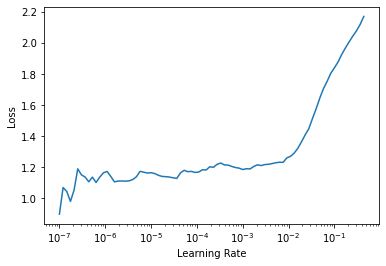

In [ ]:
lr_min,lr_steep = learn.lr_find()

In [ ]:
print((lr_min,lr_steep))

(6.309573450380412e-08, 1.3182567499825382e-06)


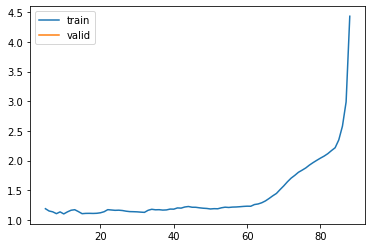

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save('/content/gdrive/My Drive/fastai/4epoch-finetune')

Path('/content/gdrive/My Drive/fastai/4epoch-finetune.pth')

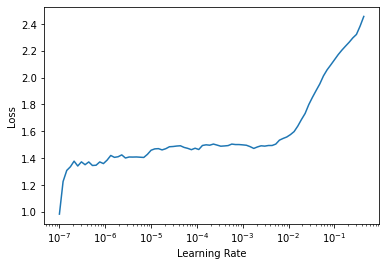

In [ ]:
lr_min,lr_steep = learn.lr_find()

## Fine Tunning Language Model before Classsification

In [ ]:
huffpost_lm = DataBlock(blocks=TextBlock.from_df('text', is_lm=True),
                        get_x=ColReader('text'),
                        splitter=ColSplitter())

In [ ]:
dls_lm = huffpost_lm.dataloaders(train_validation, bs=64, seq_len=72)
dls_lm.show_batch(max_n=6)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,xxbos xxmaj how xxmaj practice xxmaj xxunk xxmaj the xxmaj brain xxbos 8 xxmaj tips on xxmaj telling xxmaj your xxmaj kids xxmaj you 're xxmaj getting a xxmaj divorce xxbos ' groundbreaking ' xxmaj trial xxmaj will xxmaj test cancer - sniffing xxmaj dogs xxbos xxmaj legionnaires ' xxmaj disease xxmaj is xxmaj back xxmaj in xxup nyc xxmaj with xxmaj new xxmaj cluster xxbos xxmaj amber mcdonald xxmaj of xxmaj,xxmaj how xxmaj practice xxmaj xxunk xxmaj the xxmaj brain xxbos 8 xxmaj tips on xxmaj telling xxmaj your xxmaj kids xxmaj you 're xxmaj getting a xxmaj divorce xxbos ' groundbreaking ' xxmaj trial xxmaj will xxmaj test cancer - sniffing xxmaj dogs xxbos xxmaj legionnaires ' xxmaj disease xxmaj is xxmaj back xxmaj in xxup nyc xxmaj with xxmaj new xxmaj cluster xxbos xxmaj amber mcdonald xxmaj of xxmaj the
1,xxbos xxmaj remove xxmaj water xxmaj marks xxmaj from xxmaj wood xxmaj with a xxmaj hair xxmaj dryer xxbos xxmaj aly xxmaj raisman : ' this xxmaj is xxmaj bigger xxmaj than xxmaj larry xxmaj nassar ' xxbos xxmaj how xxmaj xxunk xxmaj the xxup gop xxmaj debates xxmaj could xxmaj solve xxmaj our xxmaj nation 's xxmaj energy xxmaj needs xxbos xxmaj at the xxmaj top of xxmaj my xxmaj lungs,xxmaj remove xxmaj water xxmaj marks xxmaj from xxmaj wood xxmaj with a xxmaj hair xxmaj dryer xxbos xxmaj aly xxmaj raisman : ' this xxmaj is xxmaj bigger xxmaj than xxmaj larry xxmaj nassar ' xxbos xxmaj how xxmaj xxunk xxmaj the xxup gop xxmaj debates xxmaj could xxmaj solve xxmaj our xxmaj nation 's xxmaj energy xxmaj needs xxbos xxmaj at the xxmaj top of xxmaj my xxmaj lungs :
2,"xxmaj foundation xxmaj donates $ 10 xxmaj million xxmaj to xxup usc xxmaj film xxmaj school xxbos xxmaj xxunk xxmaj xxunk xxmaj becomes xxmaj first xxup u.s . xxmaj woman xxmaj to xxmaj win xxup nyc xxmaj marathon xxmaj in 40 xxmaj years xxbos 17 xxmaj suggestions for xxmaj choosing xxmaj classes in xxmaj college xxbos ' if xxmaj the xxmaj right xxmaj people xxmaj pay xxmaj attention , xxmaj anything xxmaj","foundation xxmaj donates $ 10 xxmaj million xxmaj to xxup usc xxmaj film xxmaj school xxbos xxmaj xxunk xxmaj xxunk xxmaj becomes xxmaj first xxup u.s . xxmaj woman xxmaj to xxmaj win xxup nyc xxmaj marathon xxmaj in 40 xxmaj years xxbos 17 xxmaj suggestions for xxmaj choosing xxmaj classes in xxmaj college xxbos ' if xxmaj the xxmaj right xxmaj people xxmaj pay xxmaj attention , xxmaj anything xxmaj can"
3,"xxmaj prep xxmaj skin for xxmaj winter xxbos xxmaj celebs xxmaj reveal xxmaj trump 's ' alternative xxmaj constitution ' xxmaj in xxmaj funny xxmaj or xxmaj die xxmaj bit xxbos xxmaj sandra xxmaj valls : a xxmaj xxunk xxmaj with xxmaj comedy , xxmaj music in xxmaj her xxmaj heart xxbos xxmaj how xxmaj to xxmaj avoid xxmaj school xxmaj choice xxmaj accountability xxbos xxmaj now xxmaj that 's xxmaj what","prep xxmaj skin for xxmaj winter xxbos xxmaj celebs xxmaj reveal xxmaj trump 's ' alternative xxmaj constitution ' xxmaj in xxmaj funny xxmaj or xxmaj die xxmaj bit xxbos xxmaj sandra xxmaj valls : a xxmaj xxunk xxmaj with xxmaj comedy , xxmaj music in xxmaj her xxmaj heart xxbos xxmaj how xxmaj to xxmaj avoid xxmaj school xxmaj choice xxmaj accountability xxbos xxmaj now xxmaj that 's xxmaj what i"
4,"xxmaj readers xxmaj share xxmaj photos xxmaj of xxmaj their xxmaj pets xxmaj celebrating xxmaj their xxmaj big xxmaj days ( photos ) xxbos xxmaj drawing for the xxmaj soul xxbos ' coal 101 , ' xxmaj sierra xxmaj club xxmaj video , xxmaj targets xxmaj controversial xxmaj energy xxmaj source xxbos xxmaj why ' getting xxmaj over xxmaj it ' xxmaj is a xxmaj myth xxmaj you xxmaj should xxmaj ignore","readers xxmaj share xxmaj photos xxmaj of xxmaj their xxmaj pets xxmaj celebrating xxmaj their xxmaj big xxmaj days ( photos ) xxbos xxmaj drawing for the xxmaj soul xxbos ' coal 101 , ' xxmaj sierra xxmaj club xxmaj video , xxmaj targets xxmaj controversial xxmaj energy xxmaj source xxbos xxmaj why ' getting xxmaj over xxmaj it ' xxmaj is a xxmaj 

In [ ]:
learn_lm = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

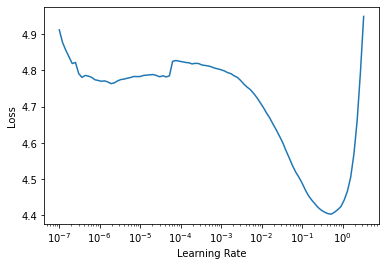

In [ ]:
lr_min,lr_steep = learn_lm.lr_find()

In [ ]:
print((lr_min,lr_steep))

(0.05248074531555176, 0.033113110810518265)


In [ ]:
learn_lm.fit_one_cycle(1, 0.044)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.123488,3.005589,0.523635,20.198118,03:54


In [ ]:
learn_lm.save('/content/gdrive/My Drive/fastai/1epoch_new')

Path('/content/gdrive/My Drive/fastai/1epoch_new.pth')

In [ ]:
learn_lm = learn_lm.load('/content/gdrive/My Drive/fastai/1epoch_new')
learn_lm.unfreeze()
learn_lm.fit_one_cycle(10, 2e-5)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.882330,2.995535,0.525793,19.996054,14:03
1,2.835341,2.967003,0.529167,19.433588,14:02
2,2.803826,2.944815,0.531793,19.007149,14:02
3,2.784666,2.929408,0.533563,18.716549,14:00
4,2.772893,2.919303,0.534686,18.528362,13:49
5,2.762440,2.912461,0.535240,18.402021,13:46
6,2.751006,2.908089,0.535916,18.321747,13:44
7,2.756729,2.906188,0.536213,18.286951,13:44
8,2.749248,2.905162,0.536299,18.268209,13:43
9,2.755079,2.905041,0.536304,18.265997,13:41


In [ ]:
learn_lm.save_encoder('/content/gdrive/My Drive/fastai/finetuned_new2')

In [ ]:
TEXT = "President Trump said yesterday: "
N_WORDS = 20
learn_lm.predict(TEXT, N_WORDS, temperature=0.4)

"President Trump said yesterday : There 's a Lot Of The Way To Be President"

In [ ]:
dls_clas = huffpost.dataloaders(train_validation, bs=64, seq_len=50, vocab=dls_lm.vocab)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
dls_clas.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj chats with xxmaj xxunk xxmaj xxunk , xxmaj michelle xxmaj phillips , xxmaj lee xxmaj xxunk , xxmaj ian xxmaj thomas and xxmaj young xxmaj gun xxmaj silver xxmaj fox 's xxmaj shawn xxmaj lee , xxmaj plus xxmaj joey xxmaj alexander , xxmaj xxunk , xxmaj xxunk xxmaj xxunk , m xxmaj ross xxmaj perkins , xxmaj morgan 's xxmaj road , xxmaj xxunk , xxmaj dave mcgraw & xxmaj mandy xxmaj xxunk , xxmaj unconscious xxmaj xxunk , i xxmaj the xxmaj mighty , and xxmaj the xxmaj junior xxmaj league xxmaj exclusives",ENTERTAINMENT
1,"xxbos xxmaj mommy xxmaj confidential : xxmaj soleil xxmaj moon xxmaj frye xxmaj reveals xxmaj her ' aha ' xxmaj mom xxmaj moment , the xxmaj one xxmaj item xxmaj always in xxmaj her xxmaj bag and the xxmaj art of xxmaj imperfect xxmaj parenting",PARENTING
2,"xxbos xxmaj julie xxmaj xxunk xxmaj and xxmaj james xxmaj xxunk , xxmaj owners xxmaj of xxmaj the xxmaj exposed xxmaj glass xxmaj shower xxmaj in xxmaj xxunk xxmaj hill , xxmaj brooklyn xxmaj respond xxmaj with xxmaj giant xxmaj letter ( photos )",HOME & LIVING


In [ ]:
learn_clas = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

In [ ]:
learn_clas = learn_clas.load_encoder('/content/gdrive/My Drive/fastai/finetuned_new2')

(0.03019951581954956, 0.019054606556892395)


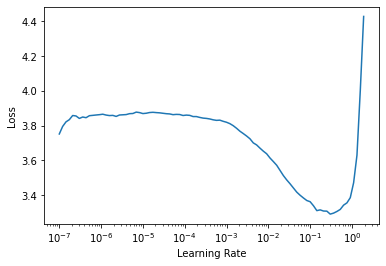

In [ ]:
lr_min,lr_steep = learn_clas.lr_find()
print((lr_min,lr_steep))

In [ ]:
learn_clas.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.063632,1.814316,0.495160,05:47


In [ ]:
learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.758300,1.602449,0.557670,06:06


In [ ]:
learn_clas.freeze_to(-3)
learn_clas.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.583106,1.432207,0.596227,07:12


In [ ]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.528085,1.387734,0.604470,09:06
1,1.407262,1.372689,0.609227,09:07


In [ ]:
learn_clas.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.438617,1.355775,0.614095,09:06
1,1.306016,1.343824,0.617470,09:07


In [ ]:
learn_clas.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.285581,1.334261,0.617857,09:06
1,1.290238,1.326815,0.621397,09:07


In [ ]:
learn_clas.save('/content/gdrive/My Drive/fastai/encoderretrained-many-epochs_new2')

Path('/content/gdrive/My Drive/fastai/encoderretrained-many-epochs_new2.pth')

In [ ]:
learn_clas.save('/content/gdrive/My Drive/fastai/encoderretrained-many-epochs_new3')

Path('/content/gdrive/My Drive/fastai/encoderretrained-many-epochs_new3.pth')

## Testing Model

In [12]:
learn = learn.load('/content/gdrive/My Drive/fastai/4epoch-finetune')

In [14]:
dls_test = dls.test_dl(test, with_labels=True, bs=1024)

In [15]:
preds = learn.get_preds(dl=dls_test)
learn.validate(dl=dls_test)

(#2) [1.3095282316207886,0.6284974813461304]

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load, dump

from sklearn.metrics import classification_report

def get_model_filename(model_name, folder_path='Data', model_name_prefix='model_'):
    return(os.path.join(folder_path,f"{model_name_prefix}{model_name}.joblib"))

def save_model(model_dict):
    filename = get_model_filename(model_dict['model_name'])
    dump(model_dict,filename)

def create_model_dict(model_name, model_description, search, test, predicted_test, rewrite=False):
    """
    Function that creates and saves all information related to a model run
    """
    filename = get_model_filename(model_name)
    if not os.path.exists(filename) or rewrite:
        test_copy = test.copy()
        test_copy['pred'] = predicted_test
        model_dict = {
            'model_name': model_name,
            'model_description': model_description,
            'model_CV': search,
            'model_results': test_copy
        }
        save_model(model_dict)
        
def consolidate_results(path='./Data'):
    """
    Function that loads model result files from given path and
    creates a Pandas dataframe with relevant information
    """
    model_files = [load(os.path.join(path, f)) 
                   for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and f.startswith('model_')]
    df_final = pd.DataFrame(columns=['model_name','train_accuracy','test_accuracy',
                                     'macro_avg_precision','macro_avg_recall',
                                     'macro_avg_f1-score','weighted_avg_precision',
                                     'weighted_avg_recall','weighted_avg_f1-score'])
    for model_file in model_files:
        results = model_file['model_results']
        class_report = classification_report(results.category, results.pred, output_dict=True)
        df_final = df_final.append({'model_name':model_file['model_name'],
                                    'train_accuracy':'{0:.2f}'.format(model_file['model_CV'].best_score_),
                                    'test_accuracy':'{0:.2f}'.format(class_report['accuracy']),
                                    'macro_avg_precision':class_report['macro avg']['precision'],
                                    'macro_avg_recall':class_report['macro avg']['recall'],
                                    'macro_avg_f1-score':class_report['macro avg']['f1-score'],
                                    'weighted_avg_precision':class_report['weighted avg']['precision'],
                                    'weighted_avg_recall':class_report['weighted avg']['recall'],
                                    'weighted_avg_f1-score':class_report['weighted avg']['f1-score']
                                   },ignore_index=True)
    return(df_final)

class GridSearchSimulation(object):
    # Class to include parameter best_score_
    # so that it does not break the code.
    def __init__(self,train_score):
        self.best_score_ = train_score

In [52]:
predictions = np.array(preds[0].argmax(dim=1).tolist())
predictions[:10]

array([25, 20, 30,  8, 24, 24, 10, 28, 25, 15])

In [60]:
model_name = 'headlines_pytorch_pretrained_NN'
model_description = 'Pytorch Pretrained Neural Network Model on headlines only'

In [20]:
trainning_score = 0.624219
gssim = GridSearchSimulation(trainning_score)

In [53]:
pred_classes = [dls.vocab[1][idx] for idx in predictions]
pred_classes[:10]

['QUEER VOICES',
 'MEDIA',
 'STYLE & BEAUTY',
 'DIVORCE',
 'POLITICS',
 'POLITICS',
 'ENTERTAINMENT',
 'SPORTS',
 'QUEER VOICES',
 'GREEN']

In [55]:
np.mean(pred_classes == test.category)

0.6284974609180524

In [61]:
create_model_dict(model_name, model_description, gssim, test, pred_classes, False)